## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Download the customer complaints json files from my google drive to colab
! gdown --id 1hHJAoqY7Vb7b0Pt6ovpHg6jn3TGl4wvP

Downloading...
From: https://drive.google.com/uc?id=1hHJAoqY7Vb7b0Pt6ovpHg6jn3TGl4wvP
To: /content/complaints.json
100% 83.4M/83.4M [00:00<00:00, 164MB/s]


In [3]:
# Opening JSON file 
f = open("/content/complaints.json")# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
print(df.head())

                _index  ... _source.consumer_consent_provided
0  complaint-public-v2  ...              Consent not provided
1  complaint-public-v2  ...                  Consent provided
2  complaint-public-v2  ...                  Consent provided
3  complaint-public-v2  ...              Consent not provided
4  complaint-public-v2  ...                               N/A

[5 rows x 22 columns]


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [6]:
df.isnull().sum()

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

In [7]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [8]:
#Assign new column names
df.columns = [column.split('.')[1] if len(column.split('.'))>1 else column.split('.')[0][1:] for column in df.columns]

In [9]:
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [10]:
# Check the total blanks in the complaints column
len(df[df['complaint_what_happened']==''])

57241

In [11]:
df[df['complaint_what_happened']=='']['complaint_what_happened']

0         
3         
4         
5         
6         
        ..
78304     
78305     
78306     
78307     
78308     
Name: complaint_what_happened, Length: 57241, dtype: object

In [12]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True)

In [13]:
df['complaint_what_happened'].isna().sum()

57241

In [14]:
#Remove all rows where complaints column is nan
df = df[df['complaint_what_happened'].notna()]

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_dataframe(data, attribute):
    data['Complaint_clean'] = data[attribute].apply(lambda x:x.lower())
    data['Complaint_clean'] = data[attribute].replace(r'\[[^)]*\]', '', regex=True)
    data['Complaint_clean'] = data[attribute].replace(r'[^\w\s]', '', regex=True)
    data['Complaint_clean'] = data[attribute].replace(r'\w*\d\w*', '',  regex=True)
    return data

In [16]:
#Write your function to Lemmatize the texts
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import swifter

wordnet_lemmatizer = WordNetLemmatizer()
def preprocess(document):
    # tokenize into words
    words = word_tokenize(document)
     # remove stop words
    words = [word for word in words if word not in stopwords.words("english")]
    words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]
    # join words to make sentence
    document = " ".join(words)
    return document

def lemmatize_dataframe(data, attribute):
    data[attribute] = data[attribute].swifter.apply(preprocess)
    return data


In [17]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = clean_dataframe(df, 'complaint_what_happened')
df_clean = lemmatize_dataframe(df_clean, 'Complaint_clean')

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [18]:
df_clean

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,Complaint_clean
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,Good morning name XXXX XXXX I appreciate could...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,I upgrade XXXX XXXX card XX/XX/ tell agent upg...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,"Chase Card report XX/XX/ . However , fraudulen..."
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,"On XX/XX/ , try book XXXX XXXX ticket , I come..."
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,grand son give check { $ . } deposit chase acc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78303,complaint-public-v2,complaint,3094545,0.0,Older American,281XX,3094545,"Advertising and marketing, including promotion...",2018-12-07T12:00:00-05:00,NC,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-07T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,After being a Chase Card customer for well ove...,Didn't receive advertised or promotional terms,Consent provided,"After Chase Card customer well decade , offer ..."
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,N/A,Credit card or prepaid card,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided,"On Wednesday , XX/XX/XXXX I call Chas , XXXX X..."
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided,I familiar XXXX pay understand great risk prov...
78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T

In [19]:
#Write your function to extract the POS tags 
model = spacy.load("en_core_web_sm",  exclude=["ner", "tagger", "parser"])
def preprocess_pos(document):
    tokens = model(document)
    words = [str(word) for word in tokens if word.pos_ in ['NOUN', 'PRON']]
    document = " ".join(words)
    return document

def extract_pos(data, attribute):
    data['complaint_POS_removed'] = data[attribute].swifter.apply(preprocess_pos)
    return data

In [20]:
df_clean = extract_pos(df_clean, "Complaint_clean")

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [21]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,Complaint_clean,complaint_POS_removed
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,Good morning name XXXX XXXX I appreciate could...,morning name I cardmember service I debt verif...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,I upgrade XXXX XXXX card XX/XX/ tell agent upg...,I card agent anniversary date It agent informa...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,"Chase Card report XX/XX/ . However , fraudulen...",report XX/ application identity consent servic...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,"On XX/XX/ , try book XXXX XXXX ticket , I come...",book ticket I offer ticket I reward card I inf...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,grand son give check { $ . } deposit chase acc...,son check deposit account money son money pay ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78303,complaint-public-v2,complaint,3094545,0.0,Older American,281XX,3094545,"Advertising and marketing, including promotion...",2018-12-07T12:00:00-05:00,NC,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-07T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,After being a Chase Card customer for well ove...,Didn't receive advertised or promotional terms,Consent provided,"After Chase Card customer well decade , offer ...",Card customer well decade solicitations credit...
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,N/A,Credit card or prepaid card,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided,"On Wednesday , XX/XX/XXXX I call Chas , XXXX X...",I provider claim protection benefit I school t...
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,N/A,Checking or sav

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




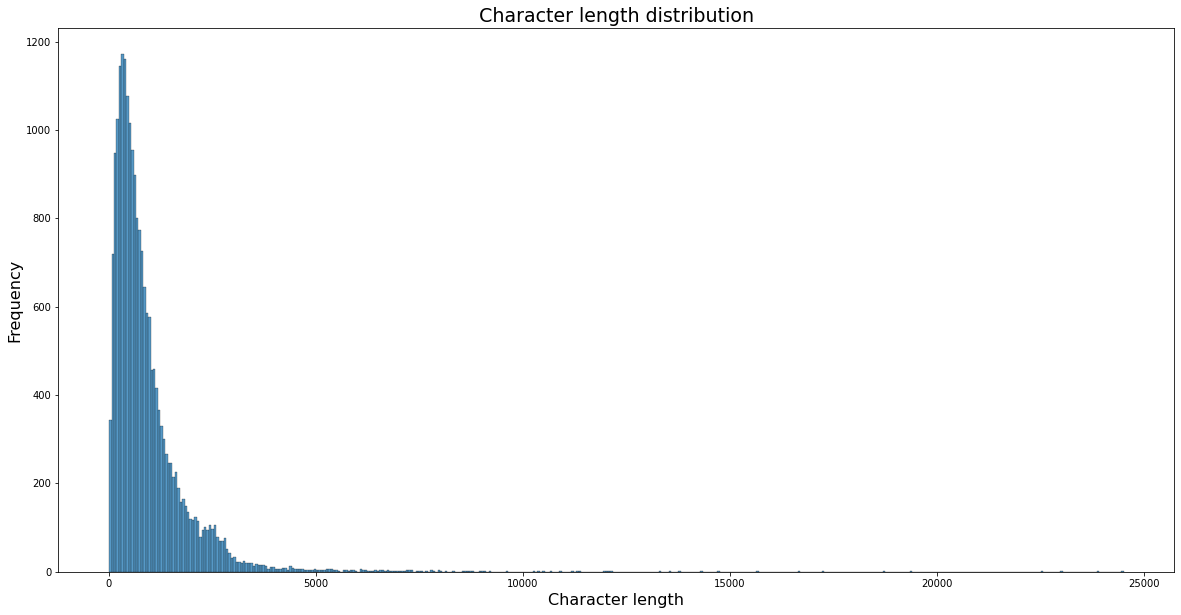

In [22]:
# Write your code here to visualise the data according to the 'Complaint' character length
import seaborn as sns
char_frequency=df_clean['Complaint_clean'].apply(lambda x:len(x))
font_size={'fontsize': 16}
title_font_size={'fontsize': 19}

plt.figure(figsize=(20,10))
sns.histplot(char_frequency)
plt.xlabel('Character length', fontdict=font_size)
plt.ylabel('Frequency', fontdict=font_size)
plt.title('Character length distribution', fontdict=title_font_size)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [23]:
 df_clean['Complaint_clean'][0:1]

1    Good morning name XXXX XXXX I appreciate could...
Name: Complaint_clean, dtype: object

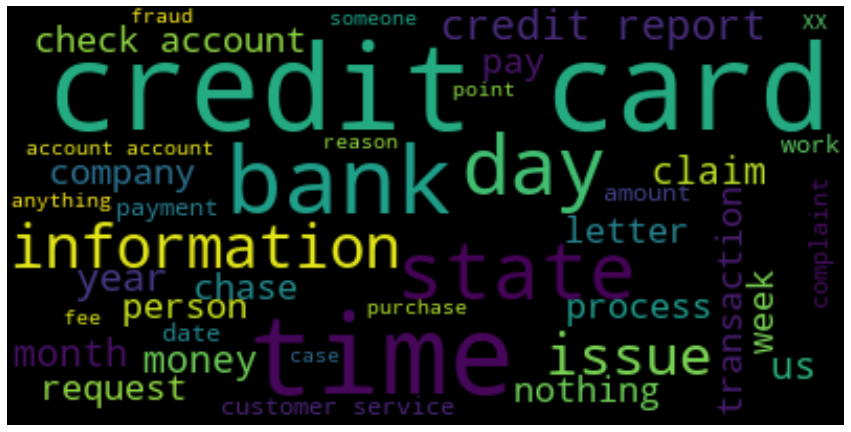

In [24]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

text="".join (words for words in df_clean['complaint_POS_removed'])
wordcloud = WordCloud(max_words=40, ).generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [26]:
# Import ngram and frequency distribution library from nltk
from nltk import ngrams, FreqDist
UNIGRAM =1
BIGRAM = 2
TRIGRAM = 3

In [27]:
# Let us define a function to return ngram
def ngram_for(text, n_gram=1):
    tokens = re.split("\\s", text)
    ngram=[]
    for i in range(len(tokens)-n_gram+1):
        temp= [tokens[j] for j in range(i, i + n_gram)]
        ngram.append(" ".join(temp))
    return ngram

In [28]:
# Let us define a function to return ngram
def get_ngram(text, n_gram=1):
    grams_list=[]
    for grams in ngrams(text.split(), n_gram):
        grams_list.append(grams)
    return grams_list

In [29]:
FreqDist(ngram_for(text, TRIGRAM)).most_common(30)

[('I I I', 2309),
 ('I credit card', 2099),
 ('credit card I', 1484),
 ('I account I', 1211),
 ('I customer service', 936),
 ('account I I', 885),
 ('credit card account', 871),
 ('credit report I', 817),
 ('credit card company', 788),
 ('check account I', 632),
 ('I money I', 617),
 ('I card I', 601),
 ('account I account', 587),
 ('I I account', 577),
 ('I time I', 570),
 ('card I I', 530),
 ('I payment I', 523),
 ('I I credit', 490),
 ('I charge I', 480),
 ('I credit report', 448),
 ('charge credit card', 413),
 ('time I I', 412),
 ('I bank account', 399),
 ('e - mail', 398),
 ('I check account', 397),
 ('I bank I', 395),
 ('I I bank', 377),
 ('I I card', 370),
 ('I I money', 366),
 ('credit score I', 357)]

In [30]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
ugram = FreqDist(ngram_for(text, UNIGRAM)).most_common(30)
ugram

[('I', 179009),
 ('account', 42642),
 ('credit', 29107),
 ('card', 26277),
 ('bank', 15749),
 ('time', 15597),
 ('charge', 14397),
 ('payment', 13078),
 ('check', 12015),
 ('money', 11098),
 ('report', 9579),
 ('loan', 9451),
 ('They', 9446),
 ('information', 9043),
 ('call', 8932),
 ('letter', 8745),
 ('state', 8091),
 ('fee', 8006),
 ('amount', 7993),
 ('number', 7912),
 ('phone', 7260),
 ('days', 7155),
 ('balance', 6950),
 ('claim', 6936),
 ('company', 6876),
 ('payments', 6864),
 ('pay', 6437),
 ('service', 6331),
 ('mortgage', 6298),
 ('fund', 6253)]

In [31]:
#Print the top 10 words in the unigram frequency
ugramwords=[]
for i in range(len(ugram)):
    ugramwords.append(ugram[i][0])
top10_words = [x for x in ugramwords if x in set(ugramwords)][:10]
top10_words

['I',
 'account',
 'credit',
 'card',
 'bank',
 'time',
 'charge',
 'payment',
 'check',
 'money']

In [32]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigram = FreqDist(ngram_for(text, BIGRAM)).most_common(30)
bigram

[('I I', 19523),
 ('credit card', 10462),
 ('account I', 8395),
 ('I account', 5503),
 ('I credit', 4773),
 ('card I', 4435),
 ('credit report', 3885),
 ('time I', 3566),
 ('I bank', 3552),
 ('check account', 3007),
 ('I card', 2839),
 ('I time', 2720),
 ('I letter', 2714),
 ('I payment', 2621),
 ('I money', 2599),
 ('customer service', 2438),
 ('charge I', 2350),
 ('I charge', 2219),
 ('money I', 2108),
 ('payment I', 2011),
 ('days I', 1838),
 ('debit card', 1682),
 ('I customer', 1675),
 ('I check', 1654),
 ('bank account', 1650),
 ('bank I', 1602),
 ('I email', 1597),
 ('report I', 1541),
 ('I branch', 1540),
 ('information I', 1529)]

In [33]:
#Print the top 10 words in the bigram frequency
bigramwords={}

for i in range(len(bigram)):
    bigramwords[bigram[i][0].split(" ")[0]]= bigram[i][1]
    bigramwords[bigram[i][0].split(" ")[1]]= bigram[i][1]
list(bigramwords.keys())[:10]

['I',
 'credit',
 'card',
 'account',
 'report',
 'time',
 'bank',
 'check',
 'letter',
 'payment']

In [34]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigram = FreqDist(ngram_for(text, TRIGRAM)).most_common(30)
trigram

[('I I I', 2309),
 ('I credit card', 2099),
 ('credit card I', 1484),
 ('I account I', 1211),
 ('I customer service', 936),
 ('account I I', 885),
 ('credit card account', 871),
 ('credit report I', 817),
 ('credit card company', 788),
 ('check account I', 632),
 ('I money I', 617),
 ('I card I', 601),
 ('account I account', 587),
 ('I I account', 577),
 ('I time I', 570),
 ('card I I', 530),
 ('I payment I', 523),
 ('I I credit', 490),
 ('I charge I', 480),
 ('I credit report', 448),
 ('charge credit card', 413),
 ('time I I', 412),
 ('I bank account', 399),
 ('e - mail', 398),
 ('I check account', 397),
 ('I bank I', 395),
 ('I I bank', 377),
 ('I I card', 370),
 ('I I money', 366),
 ('credit score I', 357)]

In [35]:
#Print the top 10 words in the trigram frequency
trigramwords={}

for i in range(len(trigram)):
    trigramwords[trigram[i][0].split(" ")[0]]= trigram[i][1]
    trigramwords[trigram[i][0].split(" ")[1]]= trigram[i][1]
    trigramwords[trigram[i][0].split(" ")[2]]= trigram[i][1]
list(trigramwords.keys())[:10]

['I',
 'credit',
 'card',
 'account',
 'customer',
 'service',
 'report',
 'company',
 'check',
 'money']

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [36]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('XXXX','')

In [37]:
#All masked texts has been removed
df_clean

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,Complaint_clean,complaint_POS_removed
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,morning name I cardmember service I debt verif...,morning name I cardmember service I debt verif...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,I card agent anniversary date It agent informa...,I card agent anniversary date It agent informa...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,report XX/ application identity consent servic...,report XX/ application identity consent servic...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,book ticket I offer ticket I reward card I inf...,book ticket I offer ticket I reward card I inf...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,son check deposit account money son money pay ...,son check deposit account money son money pay ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78303,complaint-public-v2,complaint,3094545,0.0,Older American,281XX,3094545,"Advertising and marketing, including promotion...",2018-12-07T12:00:00-05:00,NC,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-07T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,After being a Chase Card customer for well ove...,Didn't receive advertised or promotional terms,Consent provided,Card customer well decade solicitations credit...,Card customer well decade solicitations credit...
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,N/A,Credit card or prepaid card,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided,I provider claim protection benefit I school t...,I provider claim protection benefit I school t...
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,N/A,Checking or savings acc

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [38]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [39]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])
print(dtm)  # returns the row number and column number of cells which have 1 as value

  (0, 2999)	0.1678271163778439
  (0, 6346)	0.2768648576154942
  (0, 51)	0.08114547380850078
  (0, 1342)	0.2068295543072426
  (0, 3266)	0.12924827983766052
  (0, 446)	0.19473661491313415
  (0, 4027)	0.15988326787925206
  (0, 3750)	0.1621331654421775
  (0, 6717)	0.30767030587486843
  (0, 549)	0.10748501468814944
  (0, 6003)	0.17494662118832893
  (0, 6760)	0.25792737683994343
  (0, 1642)	0.5704572793050237
  (0, 5693)	0.14184906957565446
  (0, 885)	0.3677798780607142
  (0, 4039)	0.2349211893638479
  (1, 3973)	0.23215731747626622
  (1, 5098)	0.14235089494662417
  (1, 1310)	0.21284163790705196
  (1, 970)	0.1494033562025648
  (1, 6680)	0.29721656115895145
  (1, 4297)	0.1456124320901932
  (1, 1610)	0.2339315961273279
  (1, 281)	0.6158270552178067
  (1, 190)	0.5418386478992159
  :	:
  (21070, 4464)	0.3587695783889963
  (21070, 4465)	0.06935782945386743
  (21070, 2519)	0.13959658428696067
  (21070, 4453)	0.12867408526879598
  (21070, 5310)	0.08825497032163633
  (21070, 1519)	0.16827711891498678

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [40]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [41]:
dtm.shape

(21072, 6997)

In [42]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state =40, max_iter=dtm.shape[0] ) #write your code here

In [43]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

6997

In [44]:
#Print the Top15 words for each of the topics

W = nmf_model.fit_transform(dtm)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,deposit,fund,money,branch,business,transfer,balance,reason,days,cash,chase,fee
Topic 2,credit,card,report,inquiry,account,score,inquiries,company,limit,information,debt,application,bureaus,chase,letter
Topic 3,payment,loan,mortgage,payments,modification,pay,time,home,month,years,rate,property,balance,date,months
Topic 4,charge,fee,card,balance,dispute,purchase,overdraft,statement,refund,pay,merchant,service,month,transactions,time
Topic 5,claim,money,number,dispute,information,letter,phone,transaction,email,bank,fraud,time,state,contact,address


In [45]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
results = nmf_model.transform(dtm)
best_topics = results.argmax(axis=1)

In [46]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = best_topics #write your code to assign topics to each rows.

In [47]:
df_clean.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,Complaint_clean,complaint_POS_removed,Topic
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,morning name I cardmember service I debt verif...,morning name I cardmember service I debt verif...,4
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,I card agent anniversary date It agent informa...,I card agent anniversary date It agent informa...,4
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,report XX/ application identity consent servic...,report XX/ application identity consent servic...,1
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,book ticket I offer ticket I reward card I inf...,book ticket I offer ticket I reward card I inf...,1
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,son check deposit account money son money pay ...,son check deposit account money son money pay ...,0


In [48]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5).sort_values('Topic')

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,Complaint_clean,complaint_POS_removed,Topic
27,complaint-public-v2,complaint,3200365,0.0,None,462XX,3200365,Opening an account,2019-04-03T12:00:00-05:00,IN,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2019-04-03T12:00:00-05:00,None,Checking account,Yes,I opened an account with chase bank on XXXX an...,Didn't receive terms that were advertised,Consent provided,I account chase code bonus I term everything a...,I account chase code bonus I term everything a...,0
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,son check deposit account money son money pay ...,son check deposit account money son money pay ...,0
17,complaint-public-v2,complaint,3331023,0.0,None,770XX,3331023,Closing an account,2019-08-06T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-08-06T12:00:00-05:00,None,Checking account,Yes,With out notice J.P. Morgan Chase restricted m...,Funds not received from closed account,Consent provided,notice restrict account debit card XX/ I branc...,notice restrict account debit card XX/ I branc...,0
24,complaint-public-v2,complaint,3200018,0.0,None,112XX,3200018,Problems at the end of the loan or lease,2019-04-03T12:00:00-05:00,NY,N/A,Vehicle loan or lease,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-03T12:00:00-05:00,None,Loan,Yes,mishandling of this account by Chase auto and ...,Problem while selling or giving up the vehicle,Consent provided,account auto,account auto,0
35,complaint-public-v2,complaint,3251082,0.0,None,770XX,3251082,Opening an account,2019-05-22T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-22T12:00:00-05:00,None,Savings account,Yes,I opened the saving account for the {$25.00} b...,Didn't receive terms that were advertised,Consent provided,I account bonus I bonus auto transfer check I ...,I account bonus I bonus auto transfer check I ...,0
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,report XX/ application identity consent servic...,report XX/ application identity consent servic...,1
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,book ticket I offer ticket I reward card I inf...,book ticket I offer ticket I reward card I inf...,1
15,complaint-public-v2,complaint,3209411,0.0,None,None,3209411,Improper use of your report,2019-04-11T12:00:00-05:00,LA,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-11T12:00:00-05:00,None,Credit reporting,Yes,Can you please remove inquiry,Credit inquiries on your report that you don't...,Consent provided,inquiry,inquiry,1
23,complaint-public-v2,complaint,3237765,0.0,None,330XX,3237765,Incorrect informati

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [49]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0: "Bank Account services",
1: "Credit card or prepaid card",
2: "Theft/Dispute Reporting",
3: "Mortgage/Loan",
4: "Others"  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [50]:
df_clean

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,Complaint_clean,complaint_POS_removed,Topic
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,morning name I cardmember service I debt verif...,morning name I cardmember service I debt verif...,Others
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,I card agent anniversary date It agent informa...,I card agent anniversary date It agent informa...,Others
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,report XX/ application identity consent servic...,report XX/ application identity consent servic...,Credit card or prepaid card
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,book ticket I offer ticket I reward card I inf...,book ticket I offer ticket I reward card I inf...,Credit card or prepaid card
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,son check deposit account money son money pay ...,son check deposit account money son money pay ...,Bank Account services
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78303,complaint-public-v2,complaint,3094545,0.0,Older American,281XX,3094545,"Advertising and marketing, including promotion...",2018-12-07T12:00:00-05:00,NC,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-07T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,After being a Chase Card customer for well ove...,Didn't receive advertised or promotional terms,Consent provided,Card customer well decade solicitations credit...,Card customer well decade solicitations credit...,Credit card or prepaid card
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,N/A,Credit card or prepaid card,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided,I provider claim protection benefit I school t...,I provider claim protection benefit I school t...,Others
78310,complaint-public-v2,complaint,

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [51]:
#Create the dictionary again of Topic names and Topics

Topic_names =  {"Bank Account services": 0,
"Credit card or prepaid card": 1,
"Theft/Dispute Reporting": 2,
"Mortgage/Loan": 3,
"Others": 4  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [52]:
df_clean

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,Complaint_clean,complaint_POS_removed,Topic
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,morning name I cardmember service I debt verif...,morning name I cardmember service I debt verif...,4
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,I card agent anniversary date It agent informa...,I card agent anniversary date It agent informa...,4
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,report XX/ application identity consent servic...,report XX/ application identity consent servic...,1
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,book ticket I offer ticket I reward card I inf...,book ticket I offer ticket I reward card I inf...,1
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,son check deposit account money son money pay ...,son check deposit account money son money pay ...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78303,complaint-public-v2,complaint,3094545,0.0,Older American,281XX,3094545,"Advertising and marketing, including promotion...",2018-12-07T12:00:00-05:00,NC,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-07T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,After being a Chase Card customer for well ove...,Didn't receive advertised or promotional terms,Consent provided,Card customer well decade solicitations credit...,Card customer well decade solicitations credit...,1
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,N/A,Credit card or prepaid card,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided,I provider claim protection benefit I school t...,I provider claim protection benefit I school t...,4
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,N/A

In [53]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaint_what_happened', 'Topic']].copy()

In [54]:
training_data

,complaint_what_happened,Topic
1,Good morning my name is XXXX XXXX and I apprec...,4
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,4
10,Chase Card was reported on XX/XX/2019. However...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",1
14,my grand son give me check for {$1600.00} i de...,0
...,...,...
78303,After being a Chase Card customer for well ove...,1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",4
78310,I am not familiar with XXXX pay and did not un...,4
78311,I have had flawless credit for 30 yrs. I've ha...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [55]:

#Write your code to get the Vector count
vectorizer = CountVectorizer()
bow_model = vectorizer.fit_transform(training_data['complaint_what_happened'])
##print(bow_model)  # returns the rown and column number of cells which have 1 as value

#Write your code here to transform the word vector to tf-idf
tf_idf = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words='english')
dtm = tf_idf.fit_transform(training_data['complaint_what_happened'])
X = pd.DataFrame(dtm.toarray(), columns= tf_idf.get_feature_names() )
y = training_data['Topic']
print(X, y)

             00  000  000s  001   01  ...  zipcode  zombie  zone  zones  zoom
0      0.000000  0.0   0.0  0.0  0.0  ...      0.0     0.0   0.0    0.0   0.0
1      0.000000  0.0   0.0  0.0  0.0  ...      0.0     0.0   0.0    0.0   0.0
2      0.000000  0.0   0.0  0.0  0.0  ...      0.0     0.0   0.0    0.0   0.0
3      0.032330  0.0   0.0  0.0  0.0  ...      0.0     0.0   0.0    0.0   0.0
4      0.048840  0.0   0.0  0.0  0.0  ...      0.0     0.0   0.0    0.0   0.0
...         ...  ...   ...  ...  ...  ...      ...     ...   ...    ...   ...
21067  0.044342  0.0   0.0  0.0  0.0  ...      0.0     0.0   0.0    0.0   0.0
21068  0.000000  0.0   0.0  0.0  0.0  ...      0.0     0.0   0.0    0.0   0.0
21069  0.000000  0.0   0.0  0.0  0.0  ...      0.0     0.0   0.0    0.0   0.0
21070  0.141260  0.0   0.0  0.0  0.0  ...      0.0     0.0   0.0    0.0   0.0
21071  0.093057  0.0   0.0  0.0  0.0  ...      0.0     0.0   0.0    0.0   0.0

[21072 rows x 15947 columns] 1        4
2        4
10       1
1

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [56]:
# Write your code here to build any 3 models and evaluate them using the required metrics

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [57]:
# split the dateset into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=42)
print("Dimension of X_train:", X_train.shape)
print("Dimension of X_test:", X_test.shape)

Dimension of X_train: (14750, 15947)
Dimension of X_test: (6322, 15947)


### Logistic Regression

In [58]:
# Logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [59]:
# making the predictions
y_pred = logreg.predict(X_test)

In [60]:
# Checking the Confusion matrix
print("Confusion Matirx for y_test & y_pred\n",metrics.confusion_matrix(y_test,y_pred),"\n")

Confusion Matirx for y_test & y_pred
 [[ 964   25   20   24   65]
 [  23 1338   23   20   60]
 [  14   25 1164    7   51]
 [  21   38   18  664   72]
 [  53   48   43   27 1515]] 



In [61]:
# Determine the Accuracy of the Predicted model.
print("The accuracy of the logistic regression model is: ", \
                        metrics.accuracy_score(y_test,y_pred))

The accuracy of the logistic regression model is:  0.8929136349256565


### Decision Tree

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [72]:
dtree = DecisionTreeClassifier(criterion = "entropy", random_state = 42)
# Fit the tree model on training data
dtree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [73]:
#Predict the response for test dataset
y_pred = dtree.predict(X_test)

# Print the accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7274596646630813


### Random Forest

In [65]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

In [66]:
# Running the random forest with 9 trees
rfc = RandomForestClassifier(n_estimators=9)
rfc.fit(X_train , y_train)

RandomForestClassifier(n_estimators=9)

In [67]:
# Making predictions
predictions = rfc.predict(X_test)

In [68]:
# Print classification report 
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.65      0.73      0.69      1098
           1       0.72      0.84      0.77      1464
           2       0.78      0.77      0.77      1261
           3       0.72      0.54      0.61       813
           4       0.71      0.63      0.66      1686

    accuracy                           0.71      6322
   macro avg       0.71      0.70      0.70      6322
weighted avg       0.71      0.71      0.71      6322



### Naive Bayes Classifier

In [69]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [70]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

In [71]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7057893071812718
